* 학습 코드를 실행하기 전에 <b>[런타임]</b> - <b>[런타임 유형 변경]</b>에서 하드웨어 가속기를 <b>[GPU]</b>로 설정한다.

### <b>데이터 세트 다운로드</b>

* 딥러닝 모델 학습 과정에서 필요한 데이터 세트를 불러온다.

In [1]:
!git clone https://github.com/ndb7967/Materials
%cd Materials

Cloning into 'Materials'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 71 (delta 0), reused 0 (delta 0), pack-reused 70
Unpacking objects: 100% (71/71), 20.38 MiB | 11.01 MiB/s, done.
/content/Materials


### <b>라이브러리 불러오기(Load Libraries)</b>

* 딥러닝 모델 학습 과정에서 필요한 라이브러리를 불러온다.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import matplotlib.image as image
import numpy as np

### <b>데이터 세트 불러오기(Load Dataset)</b>

1. <b>데이터 증진(data augmentation)</b>을 명시하여 초기화할 수 있다.
  * 이미지를 불러올 때 어떤 방법(회전, 자르기, 뒤집기 등)을 사용할 것인지 명시한다.
2. 이후에 <b>DataLoader()</b>를 이용하여 실질적으로 데이터를 불러올 수 있다.
  * 어떤 데이터를 사용할 것인지, 배치 크기(batch size), 데이터 셔플(shuffle) 여부 등을 명시한다.
  * <b>next() 함수</b>를 이용하여 tensor 형태로 데이터를 배치 단위로 얻을 수 있다.
* <b>Reference</b>: https://github.com/ndb7967/Materials/dataset

In [3]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

transform_val = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [4]:
train_dataset = datasets.ImageFolder(
    root='dataset/fitness_classification_dataset/train_dataset',
    transform=transform_train
)
dataset_size = len(train_dataset)
train_size = int(dataset_size * 0.8)
val_size = dataset_size - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
test_dataset = datasets.ImageFolder(
    root='dataset/fitness_classification_dataset/test_dataset',
    transform=transform_test
)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

### <b>데이터 시각화(Data Visualization)</b>

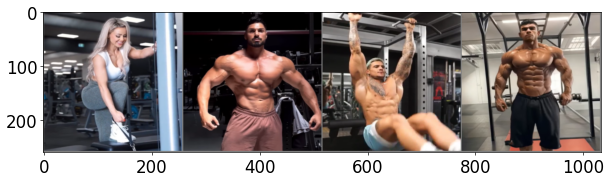

['Woman', 'Man', 'Man', 'Man']


In [5]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.show()

    
class_names = {
  0: "Man",
  1: "Woman",
  2: "Both",
}

# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
imgs, labels = next(iterator)
out = torchvision.utils.make_grid(imgs[:4])
imshow(out)
print([class_names[labels[i].item()] for i in range(4)])

### <b>딥러닝 모델 학습(Training)</b>

* 사전 학습된(pre-trained) 모델(model)을 이용하여 가지고 있는 데이터 세트에 대한 학습이 가능하다.
  * 네트워크의 마지막에 FC 레이어를 적용하여 클래스 개수를 일치시킨다.

In [6]:
learning_rate = 0.01
log_step = 20
n_classes = 3

model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes) # transfer learning
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 190MB/s]


In [7]:
import time


def train():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    model.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(train_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        outputs = model(imgs)
        optimizer.zero_grad()
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        
        if i % log_step == log_step - 1:
            print(f'[Batch: {i + 1}] running train loss: {running_loss / total}, running train accuracy: {running_corrects / total}')

    print(f'train loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()


def validate():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Validation]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(val_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running val loss: {running_loss / total}, running val accuracy: {running_corrects / total}')

    print(f'val loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()


def test():
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

In [8]:
import time

def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 5:
        lr /= 10
    if epoch >= 10:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


num_epochs = 20
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []
for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))

    if val_acc > best_val_acc:
        print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f'best_checkpoint_epoch_{epoch + 1}.pth')

torch.save(model.state_dict(), f'last_checkpoint.pth')

[Epoch: 1 - Training]
train loss: 0.1437484071804927, accuracy: 0.6153846383094788
elapsed time: 2.9523463249206543
[Epoch: 1 - Validation]
[Batch: 1] running val loss: 0.4480145275592804, running val accuracy: 0.5
val loss: 0.4480145275592804, accuracy: 0.5
elapsed time: 0.3640313148498535
[Info] best validation accuracy!
[Epoch: 2 - Training]
train loss: 0.1270849865216475, accuracy: 0.5384615659713745
elapsed time: 0.6426620483398438
[Epoch: 2 - Validation]
[Batch: 1] running val loss: 0.46024125814437866, running val accuracy: 0.75
val loss: 0.46024125814437866, accuracy: 0.75
elapsed time: 0.1374659538269043
[Info] best validation accuracy!
[Epoch: 3 - Training]
train loss: 0.062461887987760395, accuracy: 0.9230769872665405
elapsed time: 0.5916118621826172
[Epoch: 3 - Validation]
[Batch: 1] running val loss: 0.4981023967266083, running val accuracy: 0.75
val loss: 0.4981023967266083, accuracy: 0.75
elapsed time: 0.18399262428283691
[Epoch: 4 - Training]
train loss: 0.0351337011043

### <b>학습 결과 확인하기</b>

* 학습 결과를 시각화하여 정상적으로 모델이 학습되었는지 확인한다.

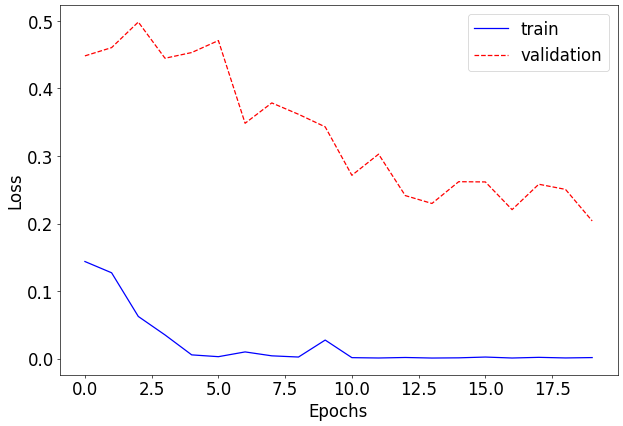

In [9]:
plt.plot([x[0] for x in history], 'b', label='train')
plt.plot([x[1] for x in history], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

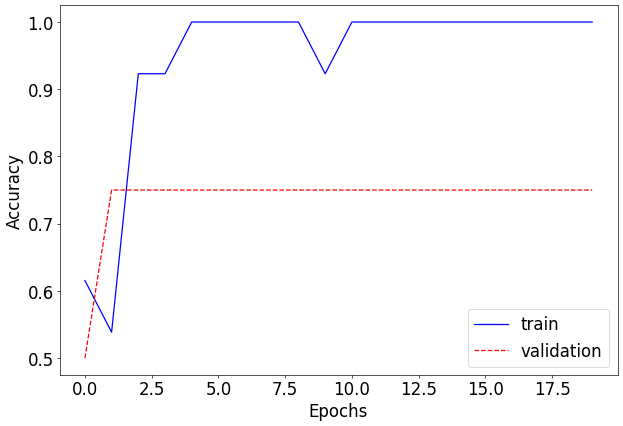

In [10]:
plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [11]:
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3) # transfer learning
model = model.cuda()
model_path = 'last_checkpoint.pth'
model.load_state_dict(torch.load(model_path))

test_loss, test_accuracy = test()
print(f"Test loss: {test_loss:.8f}")
print(f"Test accuracy: {test_accuracy * 100.:.2f}%")

[Test]
[Batch: 1] running test loss: 0.04020402207970619, running test accuracy: 0.875
test loss: 0.18863768627246222, accuracy: 0.75
elapsed time: 0.2001791000366211
Test loss: 0.18863769
Test accuracy: 75.00%
